In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score,confusion_matrix
import matplotlib.pyplot as plt

In [3]:
# 算法一：初始精度计算类
# 输入窗口长度和决策敏感性系数，输出初始精度指标（运行dos_engine）
class DosAttackDetector:
    def __init__(self, 
                 normal_dataset_filepath=r'E:\Other Program\Program\PersonalProfit\Ddos Detector\DataSet\DoS_attack_dataset_no_zero.csv', 
                 dos_dataset_filepath=r'E:\Other Program\Program\PersonalProfit\Ddos Detector\DataSet\Add_DoS_attack_dataset1.csv',
                 window_size=25, 
                 decision_sensitivity=0.5,
                 file_lines=10000
                 ):
        # 正常数据集和Dos攻击文件 ids 和timestamps列,避免重复 读取
        self.normal_dataset_ids,self.normal_dataset_timestamps = self.file_reader(normal_dataset_filepath,file_lines)
        self.dos_dataset_ids,self.dos_dataset_timestamps = self.file_reader(dos_dataset_filepath,file_lines)
        # 窗口长度
        self.window_size = window_size
        # 决策敏感度
        self.decision_sensitivity = decision_sensitivity
        ##### 其他计算精准度指标的过程中需要用到的中间数据####
        # 正常数据集各时间窗口的 ID 列表[]
        self.normal_window_ids = []
        # 正常数据集各时间窗口的信息熵列表[]
        self.normal_window_entropy = []
        # 正常数据集各时间窗口对应的时间戳列表
        self.normal_window_timestamps = []
        # 正常数据集计算出来的平均信息熵
        self.normal_window_entropy_mean = 0
        # 正常数据集计算出来的信息熵标准差
        self.normal_window_entropy_std = 0
        # 测试数据集各时间窗口的 ID 列表[]
        self.dos_window_ids = []
        # 与测试数据集各时间窗口的 ID 列表[]相对应的信息熵列表[]
        self.dos_window_entropy = []
        # 与测试数据集各时间窗口的 ID 列表[]相对应的时间戳列表[]
        self.dos_window_timestamps = []
        # 与测试数据集各时间窗口的 ID 列表[]相对应的真实标签列表[]
        self.dos_window_attack_true_labels = []
        # 与测试数据集各时间窗口的 ID 列表[]相对应的算法判定标签列表[]
        self.dos_window_attack_Ag_labels = []
        # 要输出的指标：预测准确率
        self.precision = -1
        # 要输出的指标：假阳性率
        self.fp_rate = -1
        # 所有攻击检测出来的攻击开始时间和攻击检测时间列表
        self.dos_start_timestamp = []
        self.dos_detected_timestamp = []
        # 要输出的指标：响应时间
        self.response_time = -1
    
    # 重设相关参数，更改窗口长度和决策敏感度
    def param_reset(self, window_size=25, decision_sensitivity=0.5):
        # 窗口长度
        self.window_size = window_size
        # 决策敏感度
        self.decision_sensitivity = decision_sensitivity
        ##### 其他计算精准度指标的过程中需要用到的中间数据####
        # 正常数据集各时间窗口的 ID 列表[]
        self.normal_window_ids = []
        # 正常数据集各时间窗口的信息熵列表[]
        self.normal_window_entropy = []
        # 正常数据集各时间窗口对应的时间戳列表
        self.normal_window_timestamps = []
        # 正常数据集计算出来的平均信息熵
        self.normal_window_entropy_mean = 0
        # 正常数据集计算出来的信息熵标准差
        self.normal_window_entropy_std = 0
        # 测试数据集各时间窗口的 ID 列表[]
        self.dos_window_ids = []
        # 与测试数据集各时间窗口的 ID 列表[]相对应的信息熵列表[]
        self.dos_window_entropy = []
        # 与测试数据集各时间窗口的 ID 列表[]相对应的时间戳列表[]
        self.dos_window_timestamps = []
        # 与测试数据集各时间窗口的 ID 列表[]相对应的真实标签列表[]
        self.dos_window_attack_true_labels = []
        # 与测试数据集各时间窗口的 ID 列表[]相对应的算法判定标签列表[]
        self.dos_window_attack_Ag_labels = []
        # 要输出的指标：预测准确率
        self.precision = -1
        # 要输出的指标：假阳性率
        self.fp_rate = -1
        # 所有攻击检测出来的攻击开始时间和攻击检测时间列表
        self.dos_start_timestamp = []
        self.dos_detected_timestamp = []
        # 要输出的指标：响应时间
        self.response_time = -1
    
    # 读取正常数据集文件和dos数据集文件，返回ID和TimeStamp列
    def file_reader(self, file_path,file_lines):
        res_pd = pd.read_csv(file_path,delimiter=r'\t') # delimiter=r'\t'
        timestamp = list(res_pd['TimeStamp'])[:file_lines]
        IDS = list(res_pd['ID'])[:file_lines]
        print('file loaded')
        return IDS,timestamp

    # 传入ID和TimeStamp列和时间窗长度，输出窗口ids列表和窗口时间戳列表
    def generate_windows_ids_timestamp(self, ids, timestamps, window_size):
        res_ids_list = []
        res_timestamps_list = []
        for index in range(len(ids)-window_size):
            res_ids_list.append(ids[index:index+window_size])
            res_timestamps_list.append((timestamps[index+window_size-1]))
        return res_ids_list, res_timestamps_list
    
    # 填充测试数据各时间窗口的真实标签
    def genereate_window_label(self, ids_list):
        res_label_list = []
        for window_ids in ids_list:
            if 0 in window_ids:
                res_label_list.append(1)
                continue
            res_label_list.append(0)
        return res_label_list
    
    # 填充真实数据集normal_window_ids，normal_window_timestamps
    # 填充 Dos数据集dos_window_ids，dos_window_timestamps，dos_window_attack_true_labels
    def detector_init(self,window_size):
        # 真实数据集
        ids_list,timestamps_list = self.generate_windows_ids_timestamp(self.normal_dataset_ids, 
                                                                       self.normal_dataset_timestamps,
                                                                       window_size)
        self.normal_window_ids = ids_list
        self.normal_window_timestamps = timestamps_list
        # 测试数据集

        ids_list,timestamps_list = self.generate_windows_ids_timestamp(self.dos_dataset_ids,
                                                                       self.dos_dataset_timestamps,
                                                                       window_size)
        self.dos_window_ids = ids_list
        self.dos_window_timestamps = timestamps_list
        # 填充测试数据各时间窗口的真实标签
        self.dos_window_attack_true_labels = self.genereate_window_label(self.dos_window_ids)
        
    # 输入窗口ids列表,计算各窗口的信息熵
    def calculate_entropy(self, ids_list):
        var_array,count_array =  np.unique(ids_list,return_counts=True)
        pcount_array = count_array/len(ids_list)
        return -np.sum(pcount_array*np.log(pcount_array))
    
    # 输入一个窗口的信息熵，判断这个窗口是否属于Dos攻击块,是返回1，否则返回0
    def __judge_if_dos(self, window_entropy):
        if window_entropy <= self.normal_window_entropy_mean - self.decision_sensitivity*self.normal_window_entropy_std:
            return 1
        if window_entropy >= self.normal_window_entropy_mean + self.decision_sensitivity*self.normal_window_entropy_std:
            return 1
        return 0
    
    # 计算正常数据集窗口和测试数据集窗口信息熵,正常数据集窗口信息熵均值和标准差
    def __calculate_window_entropy(self):
        # 正常数据集窗口
        self.normal_window_entropy = [self.calculate_entropy(self.normal_window_ids[index]) 
                                      for index in range(len(self.normal_window_ids))]
        self.normal_window_entropy_mean = np.mean(self.normal_window_entropy)
        self.normal_window_entropy_std = np.std(self.normal_window_entropy)
        
        # 测试数据集窗口
        self.dos_window_entropy = [self.calculate_entropy(self.dos_window_ids[index]) 
                                      for index in range(len(self.dos_window_ids))]
        
    # 判断测试数据集各窗口是否属于Dos攻击块
    def __judge_dos_window_label(self):
        self.dos_window_attack_Ag_labels = [self.__judge_if_dos(self.dos_window_entropy[index]) 
                                            for index in range(len(self.dos_window_entropy))]
    
    # 计算指标：预测准确率 以及 假阳性率
    def __calculate_precision_fp_rate(self):
        self.precision = recall_score(self.dos_window_attack_true_labels, self.dos_window_attack_Ag_labels)
        # 计算混淆矩阵
        conf_matrix = confusion_matrix(self.dos_window_attack_true_labels, self.dos_window_attack_Ag_labels)
        self.fp_rate = conf_matrix[0][1]/np.sum(conf_matrix[0])
    
    # 输入index_pos,返回搜索后的浮标index_pos，真实标签中index_pos后面（包括index_pos）第一个为1的索引，以及对应这一段攻击区间中，
    # 算法判定标签列表中第一个为1的索引，如果不存在为1的索引或者索引到头了，返回index_pos
    def attack_index_detect(self, index_pos):
        if index_pos >= len(self.dos_window_attack_true_labels):
            return index_pos
        while index_pos < len(self.dos_window_attack_true_labels) and self.dos_window_attack_true_labels[index_pos] != 1:
            index_pos += 1
        if index_pos >= len(self.dos_window_attack_true_labels):
            return index_pos
        # 能运行到这里说明找到了攻击开始时间点
        start_index = index_pos
        while index_pos < len(self.dos_window_attack_true_labels) and self.dos_window_attack_true_labels[index_pos] == 1:
            index_pos += 1
        # 攻击开始一直延续到了最后一个时间点或者找到了 ！= 1 的结束时间点
        end_index = index_pos
        # 在start_index和end_index之间搜寻dos_window_attack_Ag_labels第一个为1的index
        if 1 not in self.dos_window_attack_Ag_labels[start_index:end_index]:
            return index_pos
        detected_index = self.dos_window_attack_Ag_labels[start_index:end_index].index(1) + start_index
        return index_pos, start_index, detected_index
    
    # 计算指标：响应时间
    def __calculate_response_time(self):
        # 遍历dos_window_attack_true_labels，每次找到第一个为1的点，这个点就是攻击开始的时间
        # 然后标记这个攻击开始的时间，然后继续遍历直到找到不为1的点，这个点就是攻击结束了
        # 然后遍历dos_window_attack_Ag_labels中这标记出来的两个时间点的区间，如果全都是0
        # 那么说明算法没有将这一波攻击给识别出来，那么这一波攻击就不计算响应时间
        index_pos = 0
        while index_pos < len(self.dos_window_attack_true_labels):
            research_val = self.attack_index_detect(index_pos)
            if type(research_val) == int:
                index_pos = research_val
                continue
            index_pos = research_val[0]
            start_index = research_val[1]
            detected_index = research_val[2]
            self.dos_start_timestamp.append(self.dos_window_timestamps[start_index])
            self.dos_detected_timestamp.append(self.dos_window_timestamps[detected_index])
        # 计算平均响应时间
        self.response_time = np.mean(np.array(self.dos_detected_timestamp) - np.array(self.dos_start_timestamp))  
    
    
    # DosAttackDetector运行主程，返回三个指标：预测准确率、假阳性率以及平均响应时间
        
    # 运行主程，输出三个指标
    def dos_engine(self):
        # 初始化
        self.detector_init(window_size=self.window_size)
        # 计算正常数据集窗口和测试数据集窗口信息熵,正常数据集窗口信息熵均值和标准差
        self.__calculate_window_entropy()
        # 判断测试数据集各窗口是否属于Dos攻击块
        self.__judge_dos_window_label()
        # 计算指标：预测准确率 以及 假阳性率
        self.__calculate_precision_fp_rate()
        # 计算指标响应时间
        self.__calculate_response_time()
        return self.precision,self.fp_rate,self.response_time*1000
    
    # 输入窗口长度，计算窗口熵（for entropy_plot）
    def plot_prepare(self,window_size):
        # 初始化,计算normal_window_ids，normal_window_timestamps，dos_window_ids，dos_window_timestamps
        self.detector_init(window_size=window_size)
        # 计算正常数据集窗口和测试数据集窗口信息熵,正常数据集窗口信息熵均值和标准差
        self.__calculate_window_entropy()
    
    # 可视化熵，绘图,输入x, y, xlabel,ylabel,title,window_size
    def __entropy_plot(self, xlabel='Time', ylabel='Entropy Value',window_size=25, 
                       pic_save_dir=r'E:\Other Program\Program\PersonalProfit\Ddos Detector\ResultPic'
                       ):
        x_list = [self.normal_window_timestamps, self.dos_window_timestamps]
        y_list = [self.normal_window_entropy, self.dos_window_entropy]
        y_title_list = [r'Entropy detection(Normal dataset) sliding window length %d'%window_size,
                        r'Entropy detection(Test dataset) sliding window length %d'%window_size]
        for index in range(len(x_list)):
            plt.plot(x_list[index], y_list[index])
            plt.title(y_title_list[index])
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.savefig(pic_save_dir + r'\\' + y_title_list[index] + '.png')
            plt.show()
    
    # 可视化熵，输入窗口长度，绘制正常数据集和dos数据集窗口的熵
    def entropy_plot(self, window_size):
        # 相关计算
        self.plot_prepare(window_size)
        # 绘图
        self.__entropy_plot(window_size=window_size)
    

In [8]:
# 算法二：模拟退火优化算法一：初始精度计算类，探索最优窗口长度和决策敏感性系数
class SimuAnneal:
    def __init__(self, dos_attack_detector,
                 initial_window_size = 25,
                 window_size_research_step=0.15,
                 initial_decision_sensitivity=0.2,
                 decision_sensitivity_research_step=0.15,
                 initial_temperature=100,
                 end_temperature=1, 
                 cooling_alpha=0.9, 
                 iter_round=1000, 
                 inner_loop_round=50):
        # 初始精度计算类
        self.dos_attack_detector = dos_attack_detector
        # 初始窗口大小,窗口长度搜索步长,以及最优窗口步长
        self.window_size = initial_window_size
        self.window_size_research_step = window_size_research_step
        
        # 初始决策敏感系数，决策敏感系数搜索步长，
        self.decision_sensitivity = initial_decision_sensitivity
        self.decision_sensitivity_research_step = decision_sensitivity_research_step
        
        # 当前窗口大小和决策敏感性系数下的目标函数值（适应度）
        self.target_func_val = self.target_func(self.window_size, self.decision_sensitivity)
        self.fitness_pos = self.target_func_val[0]
        # 初始温度
        self.temperature_pos = initial_temperature
        # 迭代终止温度
        self.end_temperature = end_temperature
        # 降温系数
        self.cooling_alpha = cooling_alpha
        # 循环迭代次数
        self.iter_round = iter_round
        # 内循环迭代次数
        self.inner_loop_round = inner_loop_round
        # 当前迭代轮数
        self.iter_round_pos = 0
        # 当前最优的fitness,对应的窗口长度以及最优决策敏感系数，然后对应的三个指标
        self.best_fitness = self.fitness_pos
        self.best_decision_sensitivity = initial_decision_sensitivity
        self.best_window_size = initial_window_size
        self.best_precision = self.target_func_val[1]
        self.best_fp_rate = self.target_func_val[2]
        self.best_response_time = self.target_func_val[3]
        
        # 记录最优的fitness,对应的窗口长度以及最优决策敏感系数，然后对应的三个指标随迭代过程中的变化
        self.best_fitness_iter = []
        self.best_decision_sensitivity_iter = []
        self.best_window_size_iter = []
        self.best_precision_iter = []
        self.best_fp_rate_iter = []
        self.best_response_time_iter = []
        
    # 输入窗口大小和决策敏感系数，输出适应度（目标函数值）和其他三个指标
    def target_func(self, window_size, decision_sensitivity):
        self.dos_attack_detector.param_reset(window_size=window_size, decision_sensitivity=decision_sensitivity)
        precision,fp_rate,response_time = self.dos_attack_detector.dos_engine()
        fitness = precision - 0.5*fp_rate -response_time
        return fitness,precision,fp_rate,response_time
    
    # 迭代停止控制
    def __stop_control(self):
        return self.iter_round_pos >= self.iter_round or self.temperature_pos <= self.end_temperature
    
    # 随机在当前解周围产生新解,返回新的window_size 和新的decision_sensitivity
    def __generate_new_params(self):
        window_size = round(self.window_size + \
                      np.random.uniform(low=-self.window_size_research_step, 
                                        high=self.window_size_research_step)*self.temperature_pos)
        decision_sensitivity = self.decision_sensitivity + \
                               np.random.uniform(low=-self.decision_sensitivity_research_step, 
                                                 high=self.decision_sensitivity_research_step)*self.temperature_pos
        while True:
            self.dos_attack_detector.detector_init(window_size)
            if 0 not in self.dos_attack_detector.dos_window_attack_true_labels or 1 not in self.dos_attack_detector.dos_window_attack_true_labels:
                window_size = round(self.window_size + \
                      np.random.uniform(low=-self.window_size_research_step, 
                                        high=self.window_size_research_step)*self.temperature_pos)
                decision_sensitivity = self.decision_sensitivity + \
                               np.random.uniform(low=-self.decision_sensitivity_research_step, 
                                                 high=self.decision_sensitivity_research_step)*self.temperature_pos
                continue
            if window_size < 0 or decision_sensitivity < 0:
                window_size = round(self.window_size + \
                      np.random.uniform(low=-self.window_size_research_step, 
                                        high=self.window_size_research_step)*self.temperature_pos)
                decision_sensitivity = self.decision_sensitivity + \
                               np.random.uniform(low=-self.decision_sensitivity_research_step, 
                                                 high=self.decision_sensitivity_research_step)*self.temperature_pos
                continue
            break
        return window_size, decision_sensitivity
    
    # 更新最优解
    def __update_best_solution(self,new_window_size, new_decision_sensitivity, target_func_val):
        print('iter:',self.iter_round_pos)
        print('best_fitness:%f,'
              'best_window_size:%d,'
              'best_decision_sensitivity:%f'%(target_func_val[0], new_window_size, 
                                              new_decision_sensitivity))
        self.best_window_size = new_window_size
        self.best_decision_sensitivity = new_decision_sensitivity
        self.best_fitness = target_func_val[0]
        self.best_precision = target_func_val[1]
        self.best_fp_rate = target_func_val[2]
        self.best_response_time = target_func_val[3]
    
    # 记录最优解、最优解的适应值以及各指标随迭代过程的变化
    def iter_record(self):
        self.best_fitness_iter.append(self.best_fitness)
        self.best_decision_sensitivity_iter.append(self.best_decision_sensitivity)
        self.best_window_size_iter.append(self.best_window_size)
        self.best_precision_iter.append(self.best_precision)
        self.best_fp_rate_iter.append(self.best_fp_rate)
        self.best_response_time_iter.append(self.best_response_time)
    
    # 当前温度水平下的内部循环调整寻优过程
    def __inner_loop(self):
        for _ in range(self.inner_loop_round):
            # print('iter:',self.iter_round_pos)
            if self.__stop_control():
                break
            # 在当前解的基础上左右随机搜索产生新解
            new_window_size, new_decision_sensitivity = self.__generate_new_params()
            
            target_func_val = self.target_func(new_window_size, new_decision_sensitivity)
            new_fitness = target_func_val[0]
            dE =  self.fitness_pos - new_fitness
            if dE < 0:
                # 新解更优，接受新解
                self.window_size = new_window_size
                self.decision_sensitivity = new_decision_sensitivity
                self.fitness_pos = new_fitness
                # 将新解得fitness与最优fitness比较看是否需要更新最优解
                if new_fitness > self.best_fitness:
                    # 更新最优解
                    self.__update_best_solution(new_window_size, new_decision_sensitivity,target_func_val)
            else:
                # 新解比较差，一定给定概率接受新解
                rand_point = np.random.rand()
                if rand_point <= np.exp(-dE / self.temperature_pos):
                    self.window_size = new_window_size
                    self.decision_sensitivity = new_decision_sensitivity
                    self.fitness_pos = new_fitness
            # 记录最优解、最优解的函数值随迭代过程的变化
            self.iter_record()
            # 迭代计数加一
            self.iter_round_pos += 1
    
    # 绘制最优解和最优解的函数值随迭代而变化的过程
    def plot_iter(self, pic_save_dir):
        x = [iter_i for iter_i in range(1, len(self.best_fitness_iter) + 1)]
        y_list = [self.best_window_size_iter, self.best_decision_sensitivity_iter,
                  self.best_fitness_iter,self.best_precision_iter,
                  self.best_fp_rate_iter,self.best_response_time_iter]
        y_lable_list = ['best_window_size', 'best_decision_sensitivity',
                        'best_fitness','best_precision',
                        'best_fp_rate','best_response_time']
        for y_index in range(len(y_list)):
            plt.plot(x, y_list[y_index], label=y_lable_list[y_index])
            plt.xlabel(r'iter_round')
            plt.ylabel(y_lable_list[y_index])
            plt.savefig(pic_save_dir + r'\\SimulatedAnneal_' + y_lable_list[y_index] + '.png')
            plt.show()
    
    # 模拟退火运行主程
    def simulate_anneal_engine(self,pic_save_dir):
        while not self.__stop_control():
            # 内循环
            self.__inner_loop()
            # 一次降温
            self.temperature_pos = self.temperature_pos * self.cooling_alpha
        print('Simulated Anneal:')
        print("solution of params: {'window size':%f,'decision_sensitivity':%f}"%(self.best_window_size,self.best_decision_sensitivity))
        print('best function val of params:', self.best_fitness)
        return self.plot_iter(pic_save_dir)
            

In [9]:
# 文件路径
normal_dataset_filepath = r'H:\Other Program\Program\PersonalProfit\Ddos Detector\DataSet\DoS_attack_dataset_no_zero.csv'
dos_dataset_filepath = r'H:\Other Program\Program\PersonalProfit\Ddos Detector\DataSet\Add_DoS_attack_dataset1.csv'

In [10]:
dos_detector = DosAttackDetector(normal_dataset_filepath=normal_dataset_filepath,
                                 dos_dataset_filepath=dos_dataset_filepath,
                                 file_lines=10000)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:88: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


file loaded
file loaded


In [11]:
# 模拟退火优化
pic_save_dir = r'H:\Other Program\Program\PersonalProfit\Ddos Detector\ResultPic'
simulated_anneal_dos = SimuAnneal(dos_detector, 
                                  initial_window_size = 50,
                                  window_size_research_step=0.15,
                                  initial_decision_sensitivity=0.5,
                                  decision_sensitivity_research_step=0.0015,
                                  initial_temperature=100,
                                  end_temperature=25, 
                                  cooling_alpha=0.95, 
                                  iter_round=1000,
                                  inner_loop_round=30)

iter: 0
best_fitness:0.432870,best_window_size:49,best_decision_sensitivity:0.521826
iter: 4
best_fitness:0.442106,best_window_size:70,best_decision_sensitivity:0.684792
iter: 9
best_fitness:0.473476,best_window_size:68,best_decision_sensitivity:0.586258
iter: 14
best_fitness:0.503223,best_window_size:67,best_decision_sensitivity:0.461851
iter: 18
best_fitness:0.527615,best_window_size:82,best_decision_sensitivity:0.355086
iter: 36
best_fitness:0.557759,best_window_size:27,best_decision_sensitivity:0.372049
iter: 42
best_fitness:0.568322,best_window_size:12,best_decision_sensitivity:0.164960
iter: 48
best_fitness:0.574029,best_window_size:17,best_decision_sensitivity:0.550260
iter: 53
best_fitness:0.744384,best_window_size:8,best_decision_sensitivity:0.676849
iter: 56
best_fitness:0.774186,best_window_size:6,best_decision_sensitivity:0.633134
iter: 58
best_fitness:0.788620,best_window_size:4,best_decision_sensitivity:0.378458
iter: 402
best_fitness:0.810092,best_window_size:2,best_deci

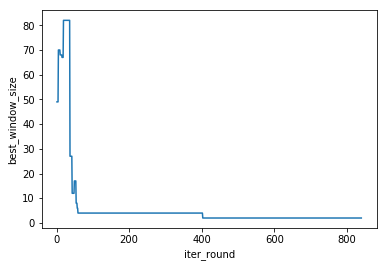

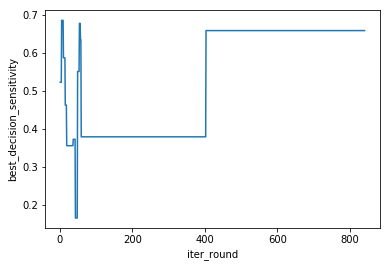

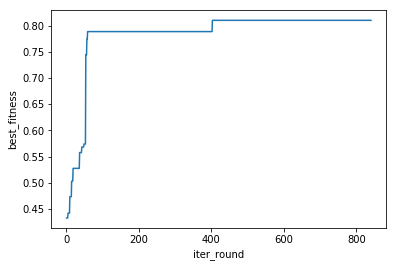

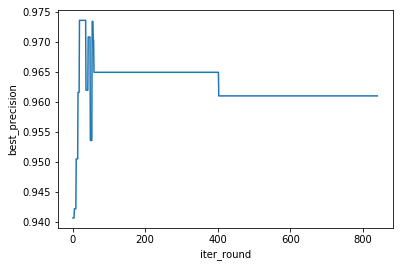

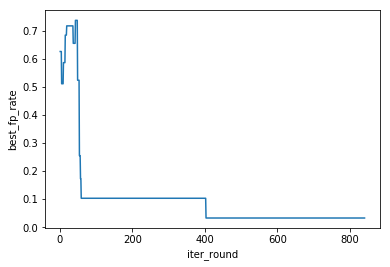

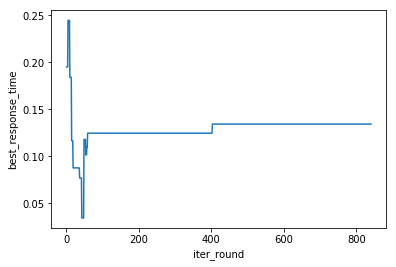

In [12]:
simulated_anneal_dos.simulate_anneal_engine(pic_save_dir=pic_save_dir)